# An exploration of the relationship between intelligence and learning

The relationship between brain structure and function has long been a central focus of neuroscientific endeavors. The dataset analyzed in this study consists of features that have been used to assess the ways in which brain size may relate to intelligence. In order to build on this investigation, we would like to examine how intelligence may related to learning. Furthermore, we aim to explore which particular intelligence features might have the greatest impact on learning.

## Load dataset
The dataset includes 40 participants with Full Scale Intelligent Quotient (FSIQ), Verbal Intelligent Quotient (VIQ), and Performance Intelligent Quotient (PIQ) scores. The brain size of each individual was determined through magnetic resonance imaging (MRI). Height and weight for each participant, and gender was specified.

Use pandas to load brain.csv data.

In [12]:
import requests

url = 'https://files.osf.io/v1/resources/6q2ge/providers/osfstorage/5ed41c6bc7568603c02d50e7'
r = requests.get(url, allow_redirects=True)   

In [16]:
open('../Original_Data/brainsize.csv', 'wb').write(r.content)

1801

In [17]:
import os
dirname = os.path.dirname('../Original_Data/')
filename = os.path.join(dirname, 'brainsize.csv')

In [18]:
import pandas as pd

csvfile = (filename)

data = pd.read_csv(csvfile, sep=';', na_values='.', index_col=0)
data.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
1,Female,133,132,124,118.0,64.5,816932
2,Male,140,150,124,NaN,72.5,1001121
3,Male,139,123,150,143.0,73.3,1038437
4,Male,133,129,128,172.0,68.8,965353
5,Female,137,132,134,147.0,65.0,951545


## Novel learning metric
This study will focus on a novel learning metric, partY.

### Generate random variable

#### Define random seed

In [9]:
import numpy as np

np.random.seed(1234)

#### Define gamma continuous random variable

In [20]:
from scipy import stats as sst

g01 = sst.gamma(100)

### Add learning metric to dataset

In [21]:
# Create pandas Series containing partY
partY = pd.Series(g01.rvs(size=data.shape[0], random_state=1234))

# Add series to pandas Dataframe containing brain size data
partY.index = np.arange(1,len(data)+1)
data['partY'] = partY

## Define multiple linear regression model

In order to investigate the relationship between learning and intelligence, we will use the features in the brain size dataset to predict the learning metric, partY.

In [53]:
from statsmodels.formula.api import ols

model = ols('partY ~ FSIQ + VIQ + PIQ + MRI_Count + Height + Weight + Gender -1', data).fit()

# Show OLS results for all regressors
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  partY   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.314
Date:                Sun, 31 May 2020   Prob (F-statistic):              0.278
Time:                        20:22:10   Log-Likelihood:                -132.96
No. Observations:                  38   AIC:                             281.9
Df Residuals:                      30   BIC:                             295.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Gender[Female]   158.5318     42.400      3.

### Perform F test

In [23]:
# Define design matrix
A = np.identity(len(model.params))
A = A[1:,:]

print(model.f_test(A))

<F test: F=array([[333.59716747]]), p=1.1843527708668696e-26, df_denom=30, df_num=7>


### Perform analysis of variance (ANOVA) test on fitted linear model

In [24]:
from statsmodels.stats.anova import anova_lm

anova_results = anova_lm(model)

print(anova_results)

,df,sum_sq,mean_sq,F,PR(>F)
Gender,2.0,385194.500562,192597.250281,2372.583443,9.375415e-34
FSIQ,1.0,6.339638,6.339638,0.078097,7.818104e-01
VIQ,1.0,71.499072,71.499072,0.880789,3.554808e-01
PIQ,1.0,409.568213,409.568213,5.045424,3.220840e-02
MRI_Count,1.0,45.128207,45.128207,0.555929,4.617075e-01
Height,1.0,49.354768,49.354768,0.607996,4.416520e-01
Weight,1.0,56.151184,56.151184,0.691720,4.121514e-01
Residual,30.0,2435.285269,81.176176,NaN,NaN


We can see from the p-value generated by the F test above that we have achieved a significant result (p=1.184e-26) for predicting partY from the brain size dataset. By examining the ANOVA results, however, we observe that there is not a significant contribution from any of the intelligence scores.

### Examine effect of individual regressors
We can assess the contribution of individual regressors via a partial regression plot. This will allow us to determine whether we might be able to remove any features that do not provide much information to the model.

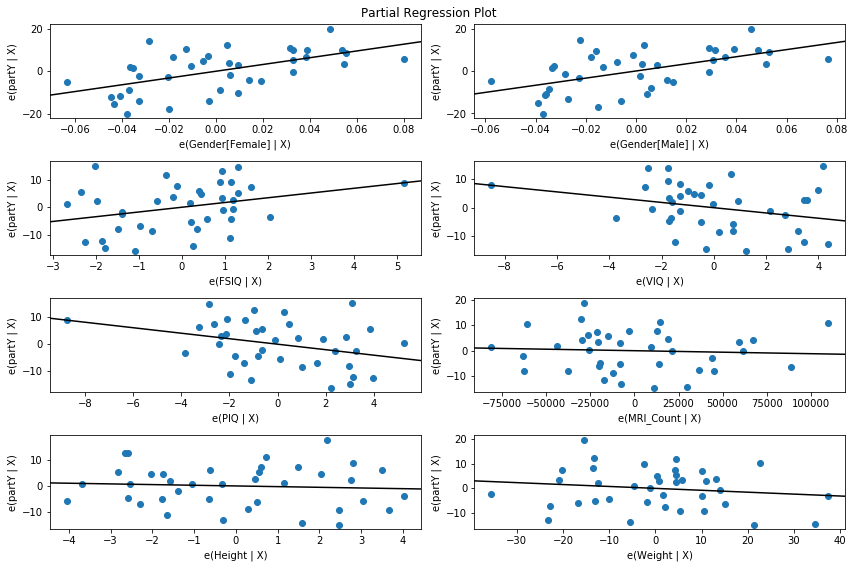

In [54]:
from statsmodels.graphics.api import plot_partregress_grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
fig = plot_partregress_grid(model, fig=fig)

Partial regression demonstrate that MRI_Count, Height, and Weight do not add much information to the model. MRI_Count is a measure of brain size, which may or may not contribute to intelligence. Height and Weight, moreover, are measures of physical size which may or may not contribute to brain size. We test the importance of these features by defining a new model composed only of intelligence scores and gender.

## Multiple linear regression without brain size features

In [25]:
model = ols('partY ~ FSIQ + VIQ + PIQ + Gender -1', data).fit()

# Show OLS results for all regressors
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  partY   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1.875
Date:                Sun, 31 May 2020   Prob (F-statistic):              0.137
Time:                        19:14:53   Log-Likelihood:                -141.33
No. Observations:                  40   AIC:                             292.7
Df Residuals:                      35   BIC:                             301.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Gender[Female]   123.3500     11.196     11.

### Perform F test

In [26]:
# Define design matrix
A = np.identity(len(model.params))
A = A[1:,:]

print(model.f_test(A))

<F test: F=array([[660.65835185]]), p=1.9829627250962393e-32, df_denom=35, df_num=4>


### Perform ANOVA

In [27]:
anova_results = anova_lm(model)

print(anova_results)

            df         sum_sq        mean_sq            F        PR(>F)
Gender     2.0  402973.851587  201486.925794  2569.485359  1.069723e-38
FSIQ       1.0      19.923499      19.923499     0.254077  6.173775e-01
VIQ        1.0      23.338030      23.338030     0.297621  5.888380e-01
PIQ        1.0     477.283960     477.283960     6.086619  1.865907e-02
Residual  35.0    2744.534963      78.415285          NaN           NaN


The F test shows that this model is even more significant for the prediction of partY. Again, however, the ANOVA results do not indicate any significant contribution from the intelligence scores. Rather, the model appears to be largely driven by Gender.

## Multiple linear regression without gender features

In [49]:
model = ols('partY ~ FSIQ + VIQ + PIQ -1', data).fit()

# Show OLS results for all regressors
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  partY   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              396.2
Date:                Sun, 31 May 2020   Prob (F-statistic):                    3.69e-28
Time:                        20:18:51   Log-Likelihood:                         -171.27
No. Observations:                  40   AIC:                                      348.5
Df Residuals:                      37   BIC:                                      353.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Perform F test

In [50]:
# Define design matrix
A = np.identity(len(model.params))
A = A[1:,:]

print(model.f_test(A))

<F test: F=array([[13.60665488]]), p=3.721074537843464e-05, df_denom=37, df_num=2>


### Perform ANOVA

In [51]:
anova_results = anova_lm(model)

print(anova_results)

            df         sum_sq        mean_sq            F        PR(>F)
FSIQ       1.0  384952.527551  384952.527551  1161.261213  1.513181e-29
VIQ        1.0     995.122013     995.122013     3.001920  9.149517e-02
PIQ        1.0    8025.959772    8025.959772    24.211390  1.802923e-05
Residual  37.0   12265.322702     331.495208          NaN           NaN
